### Librerias y Funciones

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

In [0]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql import Window
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import regexp_extract
from datetime import datetime, date
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
from optbinning import BinningProcess
from optbinning import Scorecard
from sklearn.linear_model import LogisticRegression

#### Carga de Fuente

In [0]:
int_pedidos_clientes = (spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")
                                  .withColumn("fecha_pedido_dt", F.to_date(F.col("fecha_pedido_dt")))
                        )

#### Creacion de MDT 

In [0]:
def crear_target(df_pedidos):
    # Definir ventana ordenada por fecha por cliente
    window_cliente = Window.partitionBy("cliente_id")

    # Obtener la última fecha por cliente
    df = df_pedidos.withColumn("fecha_ultimo_pedido", F.max("fecha_pedido_dt").over(window_cliente))

    # Marcar si es el último pedido
    df = df.withColumn("es_ultimo", F.when(F.col("fecha_pedido_dt") == F.col("fecha_ultimo_pedido"), 1).otherwise(0))

    # Crear el target 
    df_target = df.filter("es_ultimo = 1").select(
        "cliente_id",
        F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0).alias("target")
    )

    # eliminar clientes con mas de un pedido en la ultima fecha para evitar ambiguedades (es slo el 0.76% de los clientes)
    df_target_unica = (df_target.groupBy("cliente_id").agg(F.count("*").alias("n_pedidos_ultima_fecha"))
                                .filter("n_pedidos_ultima_fecha = 1")
                                .drop("n_pedidos_ultima_fecha")      
                      )  
                
    df_target = df_target.join(df_target_unica, on="cliente_id", how="inner")
    
    return df, df_target

def crear_historico(df, df_target):
    # Crear historico del cliente antes de su ultimo pedido
    df_historico = (df.filter(F.col("es_ultimo") == 0)
                      .join(df_target.select("cliente_id"), "cliente_id", "inner")   
                      .withColumn("dias_antes_ultimo", F.datediff(F.col("fecha_ultimo_pedido"), F.col("fecha_pedido_dt")))   
                      .withColumn("canal_pedido_cd", F.when(F.col("canal_pedido_cd") == "DIGITAL", "DIGITAL").otherwise("NO_DIGITAL"))
                    )

    df_historico = df_historico.repartition("cliente_id").persist(StorageLevel.MEMORY_AND_DISK)
    return df_historico

def agregar_variables_pedidos(df_historico):
    # Número total de pedidos anteriores
    f_pedidos = df_historico.groupBy("cliente_id").agg(
        F.count("*").alias("n_pedidos_previos"),
        F.countDistinct("canal_pedido_cd").alias("n_canales_utilizados")
    )
    return f_pedidos

def agregar_variables_frecuencia(df_historico):
    # calcular días entre pedidos
    w_orden = Window.partitionBy("cliente_id").orderBy("fecha_pedido_dt")
    df_historico = df_historico.withColumn("dias_entre_pedidos", F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w_orden)))

    # agregar canal previo y cambio de canal
    df_historico = df_historico.withColumn("canal_previo", F.lag("canal_pedido_cd").over(w_orden))
    df_historico = df_historico.withColumn("cambio_canal", F.when(F.col("canal_previo") != F.col("canal_pedido_cd"), 1).otherwise(0))

    # cambios hacia/desde digital
    df_historico = df_historico.withColumn(
        "cambio_a_digital",
        F.when((F.col("canal_previo") != "DIGITAL") & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)
    )
    df_historico = df_historico.withColumn(
        "cambio_desde_digital",
        F.when((F.col("canal_previo") == "DIGITAL") & (F.col("canal_pedido_cd") != "DIGITAL"), 1).otherwise(0)
    )

    f_frecuencia = df_historico.groupBy("cliente_id").agg(
        F.mean("dias_entre_pedidos").alias("dias_entre_pedidos_mean"),
        F.expr("percentile(dias_entre_pedidos, 0.5)").alias("dias_entre_pedidos_median"),
        F.min("dias_entre_pedidos").alias("dias_entre_pedidos_min"),
        F.max("dias_entre_pedidos").alias("dias_entre_pedidos_max")
    )
    return df_historico, f_frecuencia

def agregar_variables_canales(df_historico):
    # Conteo de cada canal
    f_canales = df_historico.groupBy("cliente_id").pivot("canal_pedido_cd").count().fillna(0)
    f_canales = (f_canales.withColumnRenamed("DIGITAL", "n_digital")
                         .withColumnRenamed("NO_DIGITAL", "n_no_digital")
                )

    # Proporción de pedidos digitales
    f_canales = f_canales.withColumn("prop_digital", F.col("n_digital")/(F.col("n_digital") + F.col("n_no_digital")))
    return f_canales

def agregar_variables_valores(df_historico):
    """# variables numericas"""
    f_valores = (df_historico.groupBy("cliente_id").agg(
        F.sum("facturacion_usd_val").alias("facturacion_total"),
        F.avg("facturacion_usd_val").alias("facturacion_prom"),
        F.stddev("facturacion_usd_val").alias("facturacion_std"),
        F.sum("materiales_distintos_val").alias("materiales_distintos_total"),
        F.avg("materiales_distintos_val").alias("materiales_prom"),
        F.stddev("materiales_distintos_val").alias("materiales_std"),
        F.sum("cajas_fisicas").alias("cajas_fisicas_total"),
        F.avg("cajas_fisicas").alias("cajas_fisicas_prom"),
        F.stddev("cajas_fisicas").alias("cajas_fisicas_std"),
    )
    .fillna(0, subset=["facturacion_std", "materiales_std", "cajas_fisicas_std"])
    )
    return f_valores

def agregar_variables_ultimo_canal(df_historico):
    # Canal mas reciente utilizado
    w_orden = Window.partitionBy("cliente_id").orderBy(F.desc("fecha_pedido_dt"))
    df_historico_ordered = df_historico.withColumn("rn", F.row_number().over(w_orden))
    
    f_ultimo_canal = (df_historico_ordered.filter(F.col("rn") == 1)
                      .select("cliente_id", "canal_pedido_cd")
                      .withColumnRenamed("canal_pedido_cd", "canal_mas_reciente")
                     )
    return f_ultimo_canal

def agregar_variables_cambio_canal(df_historico):
    # agregados de cambio de canal
    f_cambio_canal = df_historico.groupBy("cliente_id").agg(
        F.sum("cambio_canal").alias("n_cambios_canal"),
        F.mean("cambio_canal").alias("prop_cambios_canal"),
        F.sum("cambio_a_digital").alias("n_cambios_a_digital"),
        F.sum("cambio_desde_digital").alias("n_cambios_desde_digital"),
        (F.sum("cambio_a_digital") / (F.sum("cambio_canal") + F.lit(1))).alias("prop_cambios_a_digital")
    )
    return f_cambio_canal

def agregar_variables_ventanas_temporales(df_historico):
    # variables temporales
    df_historico = df_historico.withColumn("en_30d", F.when(F.col("dias_antes_ultimo") <= 30, 1).otherwise(0))
    df_historico = df_historico.withColumn("en_60d", F.when(F.col("dias_antes_ultimo") <= 60, 1).otherwise(0))
    df_historico = df_historico.withColumn("en_90d", F.when(F.col("dias_antes_ultimo") <= 90, 1).otherwise(0))

    # Crear agregados por cliente
    f_ventanas = (df_historico.groupBy("cliente_id").agg(
        F.min("dias_antes_ultimo").alias("dias_desde_ultimo_pedido"),

        F.sum("en_30d").alias("n_pedidos_ult_30d"),
        F.sum("en_60d").alias("n_pedidos_ult_60d"),
        F.sum("en_90d").alias("n_pedidos_ult_90d"),

        F.sum(F.when((F.col("en_30d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_30d"),
        F.sum(F.when((F.col("en_60d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_60d"),
        F.sum(F.when((F.col("en_90d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_90d"),
        
        F.max(F.when((F.col("en_30d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_30d"),
        F.max(F.when((F.col("en_60d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_60d"),
        F.max(F.when((F.col("en_90d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_90d")
    )
    .fillna(0, subset=["facturacion_ult_30d", "facturacion_ult_60d", "facturacion_ult_90d"])
    )
    return df_historico, f_ventanas

def agregar_variables_tendencias(df_historico, f_valores, f_canales):
    # variables de tendencias
    w = Window.partitionBy("cliente_id").orderBy(F.desc("fecha_pedido_dt"))
    df_last3 = (
        df_historico.withColumn("rn", F.row_number().over(w))
        .filter(F.col("rn") <= 3)
        .groupBy("cliente_id")
        .agg(
            F.avg("facturacion_usd_val").alias("facturacion_last3"),
            F.avg("materiales_distintos_val").alias("materiales_last3"),
            F.avg("cajas_fisicas").alias("cajas_last3")
        )
    )

    f_tendencias = df_last3.join(
        f_valores.select("cliente_id", "facturacion_prom", "materiales_prom", "cajas_fisicas_prom"),"cliente_id","left"
    )
    f_tendencias = (f_tendencias.withColumn("tendencia_facturacion", F.col("facturacion_last3") / (F.col("facturacion_prom") + F.lit(1)))
                               .withColumn("tendencia_materiales", F.col("materiales_last3") / (F.col("materiales_prom") + F.lit(1)))
                               .withColumn("tendencia_cajas", F.col("cajas_last3") / (F.col("cajas_fisicas_prom") + F.lit(1)))
                    )

    # tendencia en uso digital
    df_historico = df_historico.withColumn("canal_digital_bin", F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0))

    df_last3_digital = (
        df_historico.withColumn("rn", F.row_number().over(w))
        .filter(F.col("rn") <= 3)
        .groupBy("cliente_id")
        .agg(F.avg("canal_digital_bin").alias("uso_digital_last3"))
    )

    f_tendencia_digital = df_last3_digital.join(
        f_canales.select("cliente_id", F.col("prop_digital").alias("prop_digital_ref")),
        "cliente_id",
        "left"
    )
    f_tendencia_digital = f_tendencia_digital.fillna({"uso_digital_last3": 0, "prop_digital_ref": 0})
    f_tendencia_digital = f_tendencia_digital.withColumn(
        "tendencia_digital", F.when(F.col("uso_digital_last3") > F.col("prop_digital_ref"), 1).otherwise(0)
    )                                        

    return f_tendencias, f_tendencia_digital

def agregar_variables_fijas(df_historico):
    # variables que no cambian en el tiempo
    # Primero necesitamos obtener la fecha_ultimo_pedido para cada cliente
    window_cliente = Window.partitionBy("cliente_id")
    df_historico_con_fecha_ultima = df_historico.withColumn("fecha_ultimo_pedido", F.max("fecha_pedido_dt").over(window_cliente))
    
    f_variables_fijas = (df_historico_con_fecha_ultima.groupBy("cliente_id").agg(
        F.first("pais_cd").alias("pais_cd"),
        F.first("region_comercial_txt").alias("region_comercial_txt"),
        F.first("tipo_cliente_cd").alias("tipo_cliente_cd"),
        F.first("madurez_digital_cd").alias("madurez_digital_val"),
        F.first("estrellas_txt").cast("int").alias("estrellas_val"), 
        F.length(F.first("frecuencia_visitas_cd")).alias("frecuencia_visitas_val"),
        F.first("fecha_ultimo_pedido").cast("timestamp").alias("fecha_ultimo_pedido")
    )) 
    return f_variables_fijas

def construir_mdt(int_pedidos_clientes):
    # Función principal que construye la MDT final
    # Crear target
    df, df_target = crear_target(int_pedidos_clientes)
    
    # Crear histórico
    df_historico = crear_historico(df, df_target)
    
    # Agregar todas las variables
    f_pedidos = agregar_variables_pedidos(df_historico)
    df_historico, f_frecuencia = agregar_variables_frecuencia(df_historico)
    f_canales = agregar_variables_canales(df_historico)
    f_valores = agregar_variables_valores(df_historico)
    f_ultimo_canal = agregar_variables_ultimo_canal(df_historico)
    f_cambio_canal = agregar_variables_cambio_canal(df_historico)
    df_historico, f_ventanas = agregar_variables_ventanas_temporales(df_historico)
    f_tendencias, f_tendencia_digital = agregar_variables_tendencias(df_historico, f_valores, f_canales)
    f_variables_fijas = agregar_variables_fijas(df_historico)

    # mdt final
    df_mdt = (f_pedidos
              .join(f_canales, "cliente_id", "left")
              .join(f_valores, "cliente_id", "left")
              .join(f_frecuencia, "cliente_id", "left")
              .join(f_ventanas, "cliente_id", "left")
              .join(f_tendencias.select("cliente_id", "tendencia_facturacion", "tendencia_materiales", "tendencia_cajas"), "cliente_id", "left")
              .join(f_tendencia_digital.select("cliente_id", "uso_digital_last3", "tendencia_digital"), "cliente_id", "left")
              .join(f_ultimo_canal, "cliente_id", "left")
              .join(f_cambio_canal, "cliente_id", "left")  
              .join(f_variables_fijas, "cliente_id", "left")
              .join(df_target, "cliente_id", "inner")
    )
    
    return df_mdt

#### Modelamiento

In [0]:
df_mdt_pd = df_mdt.toPandas()

##### Division Train Test

In [0]:
df_features_pd = df_mdt_pd.copy()

df_features_pd = df_features_pd.fillna(0)

#df_features_pd = df_features_pd.drop(columns=["madurez_digital_val"])

# dividir en train y test
df_features_pd["fecha_ultimo_pedido"] = df_features_pd["fecha_ultimo_pedido"].dt.date
df_train = df_features_pd[df_features_pd["fecha_ultimo_pedido"] < date(2024,8,1)]
df_test = df_features_pd[df_features_pd["fecha_ultimo_pedido"] >= date(2024,8,1)]

##### Validacion de balance en muestras y target

In [0]:
# proporcion train/test
df_test.shape[0] / (df_test.shape[0] + df_train.shape[0])

0.27385232766398687

In [0]:
# proporcion de target en train
df_train["target"].value_counts(normalize=True)

target
0    0.520158
1    0.479842
Name: proportion, dtype: float64

In [0]:
# proporcion de target en test
df_test["target"].value_counts(normalize=True)

target
0    0.517309
1    0.482691
Name: proportion, dtype: float64

##### LightGBM

In [0]:
# creacion de df de entrenamiento y prueba
cols_exclude = ["cliente_id", "fecha_ultimo_pedido", "target"]

X_train = df_train.copy().drop(cols_exclude, axis=1)
X_test = df_test.copy().drop(cols_exclude, axis=1)

y_train = df_train.copy()["target"]
y_test = df_test.copy()["target"]

# tratamiento adicional de categoricas

categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# modelo con algunos paramtros modificados para evitar sobreajuste 

model = LGBMClassifier(
    objective="binary",
    learning_rate=0.01,
    n_estimators=1200, # menos arboles
    num_leaves=31, # reduce complejidad de arboles
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3.0, # penaliza pesos grandes
    reg_lambda=3.0, # distribuye importancia en features
    min_child_samples=150,
    class_weight="balanced",
    random_state=2022
)


# Callbacks para early stopping y logging
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.log_evaluation(period=0) 
]

# Entrenar (sin early_stopping_rounds directo)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=callbacks,
    categorical_feature=categorical_cols  
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 51749, number of negative: 56097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5384
[LightGBM] [Info] Number of data points in the train set: 107846, number of used features: 47
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, max_depth=6, min_child_samples=150,
               n_estimators=1200, objective='binary', random_state=2022,
               reg_alpha=3.0, reg_lambda=3.0, subsample=0.8)

##### Metricas Train

In [0]:
# Evaluación Train
y_pred_train = model.predict(X_train)
y_proba_train = model.predict_proba(X_train)[:, 1]

print("ROC AUC:", roc_auc_score(y_train, y_proba_train))
print("Classification report:\n", classification_report(y_train, y_pred_train))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ROC AUC: 0.6612782797043171
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     56097
           1       0.61      0.63      0.62     51749

    accuracy                           0.63    107846
   macro avg       0.63      0.63      0.63    107846
weighted avg       0.63      0.63      0.63    107846



##### Metricas Test

In [0]:
# Evaluación Test
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
print("Classification report:\n", classification_report(y_test, y_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ROC AUC: 0.648688707290185
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.63     21040
           1       0.61      0.63      0.62     19632

    accuracy                           0.63     40672
   macro avg       0.63      0.63      0.63     40672
weighted avg       0.63      0.63      0.63     40672



##### Analisis de Caracteristicas

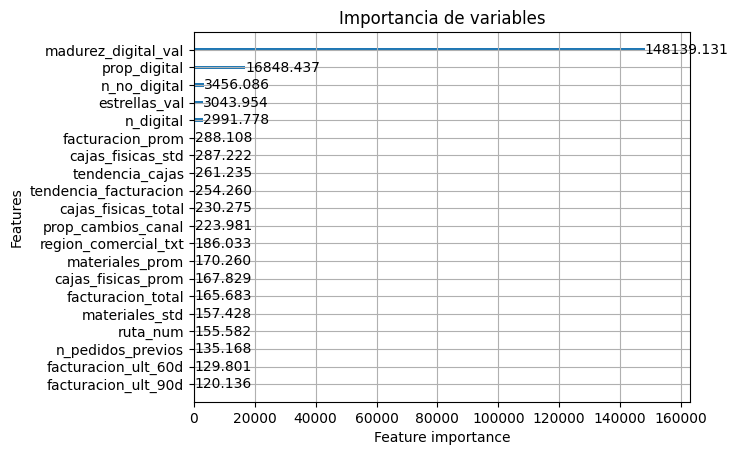

In [0]:
# importancia de caracteristicas
lgb.plot_importance(model, max_num_features=20, importance_type='gain') 
plt.title("Importancia de variables")
plt.show()

##### Analisis por segmentos de madurez

In [0]:
df_test_2 = df_test.copy()
df_test_2["madurez_digital_val"] = df_mdt_pd.loc[df_test_2.index, "madurez_digital_val"].values

# Evaluar por cada nivel de madurez
for nivel in df_test_2["madurez_digital_val"].dropna().unique():
    subset = df_test_2[df_test_2["madurez_digital_val"] == nivel]
    X_seg = X_test.loc[subset.index]
    y_seg = y_test.loc[subset.index]
    
    preds_proba = model.predict_proba(X_seg)[:, 1]
    preds_bin = (preds_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_seg, preds_proba)
    cm = confusion_matrix(y_seg, preds_bin)
    
    print(f"\n=== {nivel} ===")
    print(f"AUC: {auc:.4f}")
    print("Matriz de confusión:")
    print(cm)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== BAJA ===
AUC: 0.4948
Matriz de confusión:
[[10998  2099]
 [ 6049  1141]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== ALTA ===
AUC: 0.5000
Matriz de confusión:
[[ 111 1374]
 [ 301 4261]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== MEDIA ===
AUC: 0.5000
Matriz de confusión:
[[2545 3913]
 [3092 4788]]


##### Regresion Logística + Binning

In [0]:
var = [
    'madurez_digital_val',
    'prop_digital',
    'n_no_digital',
    'estrellas_val',
    'n_digital',
    'facturacion_prom'
]

# Criterios y parámetros
selection_criteria = {
   "iv": {"min": 0.01, "max": 10},
   "quality_score": {"min": 0.0001},
}

binning_fit_params = {}

# Asegurar tipos de datos correctos 
categorical_cols = X_train[var].select_dtypes(include=["object", "category"]).columns.tolist()
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Crear proceso de binning
binning_process = BinningProcess(
    variable_names=var,
    categorical_variables=categorical_cols,
    max_n_bins=5,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params
)

# Transformar datos 
X_train_binned = binning_process.fit_transform(X_train[var], y_train)
X_test_binned = binning_process.transform(X_test[var])

# Entrenar modelo 
model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=2022
)
model.fit(X_train_binned, y_train)

# Evaluación TRAIN
print("=== MÉTRICAS TRAIN ===")
y_pred_train = model.predict(X_train_binned)
y_proba_train = model.predict_proba(X_train_binned)[:, 1]

print("Matriz de Confusión:")
print(confusion_matrix(y_train, y_pred_train))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))

balanced_acc = balanced_accuracy_score(y_train, y_pred_train)
auc = roc_auc_score(y_train, y_proba_train)
gini = 2 * auc - 1

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")

# Evaluación TEST
print("\n=== MÉTRICAS TEST ===")
y_pred_test = model.predict(X_test_binned)
y_proba_test = model.predict_proba(X_test_binned)[:, 1]

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_proba_test)
gini = 2 * auc - 1

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"Gini: {gini:.4f}")


=== MÉTRICAS TRAIN ===
Matriz de Confusión:
[[35110 20987]
 [18910 32839]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     56097
           1       0.61      0.63      0.62     51749

    accuracy                           0.63    107846
   macro avg       0.63      0.63      0.63    107846
weighted avg       0.63      0.63      0.63    107846


Balanced Accuracy: 0.6302
ROC AUC: 0.6519
Gini: 0.3037

=== MÉTRICAS TEST ===
Matriz de Confusión:
[[13097  7943]
 [ 7190 12442]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     21040
           1       0.61      0.63      0.62     19632

    accuracy                           0.63     40672
   macro avg       0.63      0.63      0.63     40672
weighted avg       0.63      0.63      0.63     40672


Balanced Accuracy: 0.6281
ROC AUC: 0.6493
Gini: 0.2985
